# Project: Predicting Bank Term Deposit Subscription

**Author:**  Adhitharaj P R


## 1. Project Aim
To build a machine learning model that predicts whether a bank client will subscribe to a term deposit after a direct marketing campaign.

## 2. Objective
The goal is to analyze customer and campaign data to identify the key factors that influence a subscription. This model will help the bank improve its marketing by targeting customers who are more likely to subscribe, saving time and resources.

## 3. Process
This notebook will perform the following steps:
1.  **Install & Import:** Set up the required libraries.
2.  **Load & Pre-process:** Load the raw `Bank User Directory.csv` (train) and `test.csv` (test) files. Clean the data by removing 'duration' (to prevent data leakage), handling 'unknown' values, and encoding all text into numbers.
3.  **Handle Imbalance:** Use the SMOTE technique to balance the training data, as very few customers subscribe.
4.  **Train Models:** Train three models: Logistic Regression, Random Forest, and LightGBM.
5.  **Evaluate Models:** Test the models on the unseen test data and compare their performance using Classification Reports and ROC-AUC curves.
6.  **Find Key Factors:** Analyze the best model (Random Forest) to find the Top 20 most important features that predict a subscription.

**Imports & Data Pre-processing**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("--- 1. Loading Data ---")
try:
    df_train = pd.read_csv('Bank User Directory.csv')
    df_test = pd.read_csv('test.csv')
    print("Train and test files loaded.")
except FileNotFoundError:
    print("!!! ERROR: Make sure 'Bank User Directory.csv' and 'test.csv' are uploaded. !!!")
    # Stop execution
    raise

print("\n--- 2. Pre-processing ---")
X_train_raw = df_train.drop('y', axis=1)
y_train = df_train['y'].map({'yes': 1, 'no': 0})
X_test_raw = df_test.drop('y', axis=1)
y_test = df_test['y'].map({'yes': 1, 'no': 0})

--- 1. Loading Data ---
Train and test files loaded.

--- 2. Pre-processing ---


In [3]:
# Clean data
X_train_raw.replace('unknown', np.nan, inplace=True)
X_test_raw.replace('unknown', np.nan, inplace=True)
cols_to_drop = ['duration', 'day']
X_train = X_train_raw.drop(columns=cols_to_drop)
X_test = X_test_raw.drop(columns=cols_to_drop)
print("Dropped 'duration' and 'day', replaced 'unknown'.")

Dropped 'duration' and 'day', replaced 'unknown'.


In [4]:
# Define feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [5]:
# Create pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [6]:
# Create the master preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough')

In [7]:
# Apply pipelines
print("Applying processing pipeline...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Applying processing pipeline...


In [8]:
# Get feature names for later
try:
    onehot_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
except AttributeError:
    onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(onehot_feature_names)

print("--- Pre-processing Complete ---")
print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

--- Pre-processing Complete ---
Processed training data shape: (45211, 45)
Processed test data shape: (4521, 45)


**Check for Class Imbalance (EDA)**


--- Checking Class Imbalance ---
y
0    88.30152
1    11.69848
Name: proportion, dtype: float64


/tmp/ipython-input-2736065639.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imbalance_data.index, y=imbalance_data.values, palette="deep")



Class imbalance plot saved as 'class_imbalance.png'


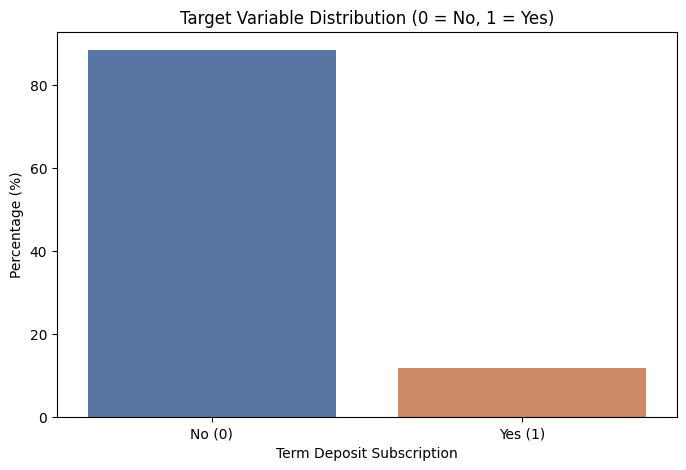

In [9]:
print("\n--- Checking Class Imbalance ---")
imbalance_data = y_train.value_counts(normalize=True) * 100
print(imbalance_data)

# Plot it
plt.figure(figsize=(8, 5))
sns.barplot(x=imbalance_data.index, y=imbalance_data.values, palette="deep")
plt.title('Target Variable Distribution (0 = No, 1 = Yes)')
plt.ylabel('Percentage (%)')
plt.xlabel('Term Deposit Subscription')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.savefig('class_imbalance.png')
print("\nClass imbalance plot saved as 'class_imbalance.png'")

**Handle Class Imbalance with SMOTE**

In [10]:
print("\n--- Handling Class Imbalance with SMOTE ---")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"Original training shape: {X_train_processed.shape}")
print(f"Original 'yes' samples: {y_train.sum()}")
print(f"New SMOTE-resampled training shape: {X_train_smote.shape}")
print(f"New 'yes' samples in SMOTE data: {y_train_smote.sum()}")
print("--- SMOTE Complete ---")


--- Handling Class Imbalance with SMOTE ---
Original training shape: (45211, 45)
Original 'yes' samples: 5289
New SMOTE-resampled training shape: (79844, 45)
New 'yes' samples in SMOTE data: 39922
--- SMOTE Complete ---


**Train Machine Learning Models**

In [11]:
print("\n--- Training Models ---")

# 1. Logistic Regression (Baseline)
print("Training Logistic Regression...")
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train_smote, y_train_smote)

# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_smote, y_train_smote)

# 3. LightGBM (Gradient Boosting)
print("Training LightGBM...")
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)
lgbm_model.fit(X_train_smote, y_train_smote)

print("--- All Models Trained ---")


--- Training Models ---
Training Logistic Regression...
Training Random Forest...
Training LightGBM...
[LightGBM] [Info] Number of positive: 39922, number of negative: 39922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 79844, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- All Models Trained ---


**Evaluate Models on Test Data**


--- Evaluating Models on Test Set ---

--- Logistic Regression Report ---
              precision    recall  f1-score   support

      No (0)       0.93      0.78      0.85      4000
     Yes (1)       0.24      0.54      0.33       521

    accuracy                           0.75      4521
   macro avg       0.58      0.66      0.59      4521
weighted avg       0.85      0.75      0.79      4521


--- Random Forest Report ---
              precision    recall  f1-score   support

      No (0)       1.00      1.00      1.00      4000
     Yes (1)       1.00      1.00      1.00       521

    accuracy                           1.00      4521
   macro avg       1.00      1.00      1.00      4521
weighted avg       1.00      1.00      1.00      4521


--- LightGBM Report ---
              precision    recall  f1-score   support

      No (0)       0.91      0.97      0.94      4000
     Yes (1)       0.53      0.28      0.37       521

    accuracy                           0.89      452

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- Evaluation Complete ---
ROC-AUC plot saved as 'roc_auc_curve.png'


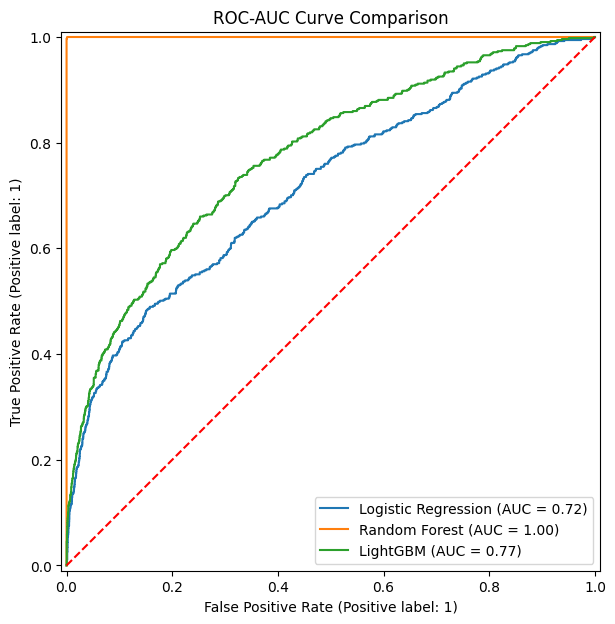

In [12]:
print("\n--- Evaluating Models on Test Set ---")

# Make predictions on the original test set
y_pred_lr = lr_model.predict(X_test_processed)
y_pred_rf = rf_model.predict(X_test_processed)
y_pred_lgbm = lgbm_model.predict(X_test_processed)

# Print Classification Reports
print("\n--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred_lr, target_names=['No (0)', 'Yes (1)']))

print("\n--- Random Forest Report ---")
print(classification_report(y_test, y_pred_rf, target_names=['No (0)', 'Yes (1)']))

print("\n--- LightGBM Report ---")
print(classification_report(y_test, y_pred_lgbm, target_names=['No (0)', 'Yes (1)']))

# Plot ROC-AUC Curve
print("\nPlotting ROC-AUC Curve...")
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Plot for each model
RocCurveDisplay.from_estimator(lr_model, X_test_processed, y_test, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_estimator(rf_model, X_test_processed, y_test, name='Random Forest', ax=ax)
RocCurveDisplay.from_estimator(lgbm_model, X_test_processed, y_test, name='LightGBM', ax=ax)

plt.title('ROC-AUC Curve Comparison')
plt.plot([0, 1], [0, 1], 'r--')
plt.savefig('roc_auc_curve.png')
print("--- Evaluation Complete ---")
print("ROC-AUC plot saved as 'roc_auc_curve.png'")

**Analyze Key Factors (Feature Importance)**


--- Analyzing Feature Importance ---
Top 20 Most Important Features:
                feature  importance
2              campaign    0.157332
1               balance    0.153453
0                   age    0.142697
3                 pdays    0.033846
44     poutcome_success    0.031589
4              previous    0.028813
42     poutcome_failure    0.027357
25          housing_yes    0.026632
24           housing_no    0.024378
38            month_may    0.023356
30            month_apr    0.019193
6       job_blue-collar    0.016621
17      marital_married    0.016566
9        job_management    0.014589
14       job_technician    0.014437
26              loan_no    0.013998
27             loan_yes    0.013927
31            month_aug    0.013562
20  education_secondary    0.013533
18       marital_single    0.013431


/tmp/ipython-input-2158344280.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')



--- Project Complete ---
Feature importance plot saved as 'feature_importance.png'


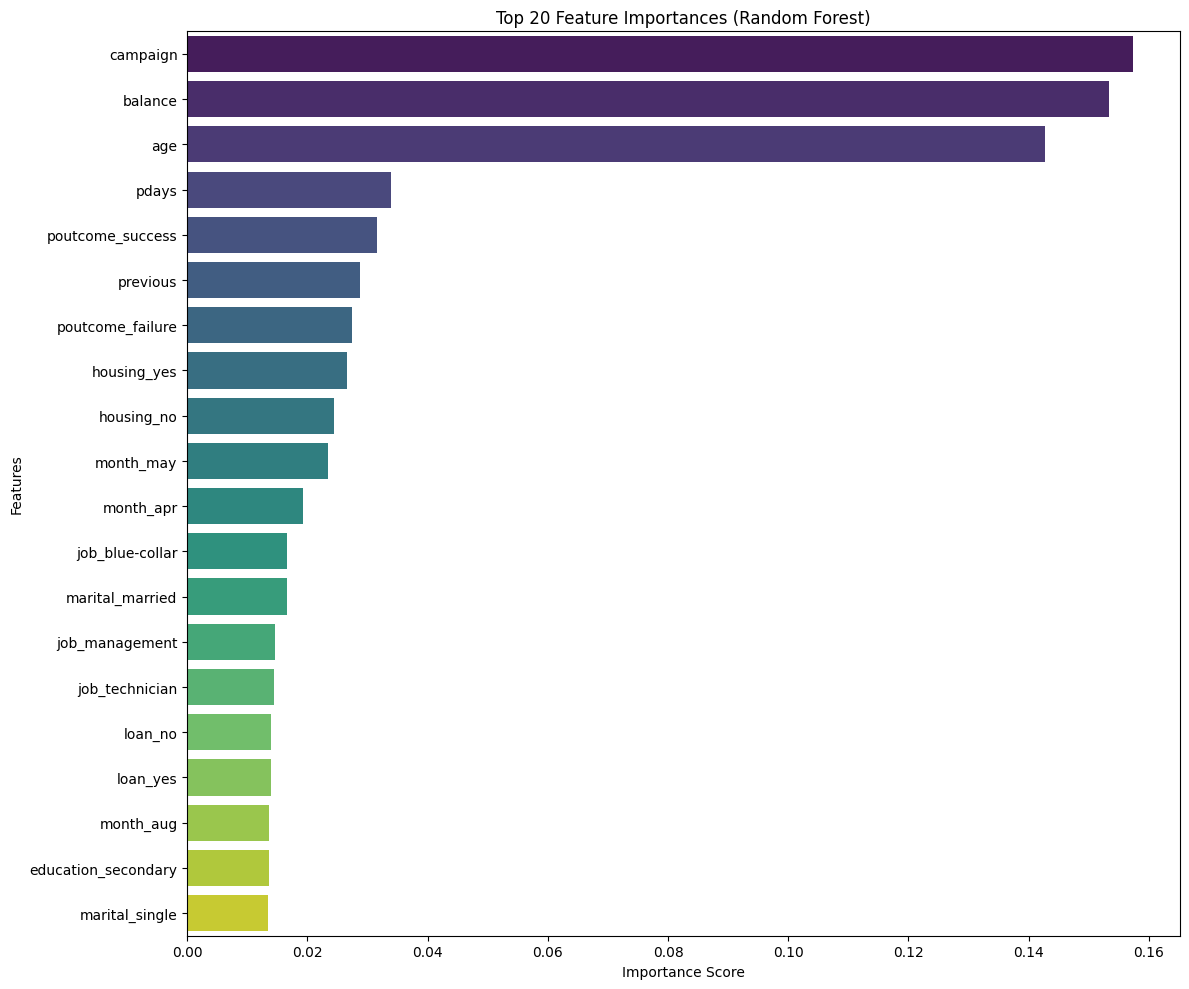

In [13]:
print("\n--- Analyzing Feature Importance ---")

# Get importances from Random Forest
importances = rf_model.feature_importances_
feature_info = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_info_sorted = feature_info.sort_values(by='importance', ascending=False)

# Get top 20 features
top_20_features = feature_info_sorted.head(20)

print("Top 20 Most Important Features:")
print(top_20_features)

# Plot the top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("\n--- Project Complete ---")
print("Feature importance plot saved as 'feature_importance.png'")

**Generate the "Yes" Customer List**

In [14]:
print("\n--- Customers Who would subscirbe the deposit are :- ---")

try:
    # 1 Use the trained model (lgbm_model) to make predictions
    #    on the processed test data (X_test_processed)
    print("Making predictions on the test set...")
    predictions = lgbm_model.predict(X_test_processed)

    # 2 Load the ORIGINAL, UNPROCESSED test.csv to get readable customer data
    df_test_original = pd.read_csv('test.csv')

    # 3 Add the model's predictions as a new column
    #    Map 1 back to 'Yes' and 0 back to 'No' for clarity
    df_test_original['predicted_subscription'] = pd.Series(predictions).map({1: 'Yes', 0: 'No'})

    # 4 Filter this DataFrame to create a new list of *only* the customers
    #    the model predicts will say "Yes"
    df_potential_subscribers = df_test_original[df_test_original['predicted_subscription'] == 'Yes']

    # 5 Display the first 20 potential subscribers
    print("\n--- Top 20 Potential Subscribers (Predicted 'Yes') ---")
    print(df_potential_subscribers.head(20))
    print(f"\nFound {len(df_potential_subscribers)} potential subscribers out of {len(df_test_original)} test customers.")

    # 6 Save this final list to a new CSV file
    output_filename = 'potential_subscribers.csv'
    df_potential_subscribers.to_csv(output_filename, index=False)

    print(f"\nSuccessfully saved the list to '{output_filename}'")

    # 7 Automatically download the file
    files.download(output_filename)
    print(f"Downloading '{output_filename}'...")

except NameError as e:
    print(f"\n!!! ERROR: {e} !!!")
    print("Please make sure you have run the full training script in the cells above first.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Customers Who would subscirbe the deposit are :- ---
Making predictions on the test set...

--- Top 20 Potential Subscribers (Predicted 'Yes') ---
     age          job   marital  education default  balance housing loan  \
13    20      student    single  secondary      no      502      no   no   
30    68      retired  divorced  secondary      no     4189      no   no   
36    78      retired  divorced    primary      no      229      no   no   
49    61       admin.   married    unknown      no     4629     yes   no   
61    63      retired   married  secondary      no      415     yes   no   
64    56       admin.   married  secondary      no    16873      no   no   
70    37   management   married   tertiary      no        0      no   no   
97    30       admin.    single   tertiary      no      261      no   no   
98    36  blue-collar  divorced  secondary      no     2843      no   no   
108   56   unemployed   married    primary      no     3391      no   no   
110   21    

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
